# Homework 2 Solution Scripts

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set() # Plot styling

In [105]:
coordinates = pd.read_csv('coordinates_2_.csv')
demands = pd.read_csv('demand_2_.csv')
costs = pd.read_csv('costs_2_.csv')

A = np.asarray(coordinates) #first column= index of customer, second and third column= coordinates
H = np.asarray(demands) #first column= index of customer, second column= demand
C = np.asarray(costs)   ##first column= index of facility, "i"th columns= cost of transporting 1 unit to the customer point "i"
C = C[:,1:]  # index column is removed

In [111]:
def squaredDistSolforSingle(H=[], A=[], C=[], m=41):
    facility_m = C[m] #cost vector of facility m: cost of transporting 1 unit from facility m to customer points
                                     #np.multiply(H[:,1],facility_m ->> output : element wise multiplier of cost vector and demand values
                                     #np.dot(H[:,1], facility_m) ->> output: total cost of transportation of demand
                                     #np.multiply(np.multiply(H[:,1],facility_m),A[:,1]) ->> weighted average of coordinates   
    x_v1_star = (np.sum(np.multiply(np.multiply(H[:,1],facility_m),A[:,1]))/np.dot(H[:,1], facility_m))
    x_v2_star = (np.sum(np.multiply(np.multiply(H[:,1],facility_m),A[:,2]))/np.dot(H[:,1], facility_m))
    
    return x_v1_star, x_v2_star

20.5860754508008

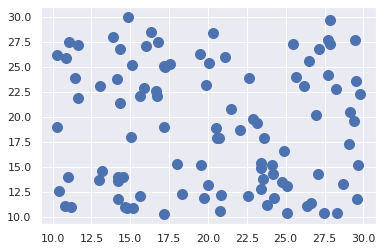

In [107]:
plt.scatter(A[:, 1], A[:, 2], s=np.size(A,axis=0))

x1, x2 = squaredDistSolforSingle(H,A,C,41)
x1


In [112]:

def ALAHeuristics(H=[], A=[], C=[], index_array=np.arange(100), seed=440): 
    # Initial step, random assignments of customers
    facility_customers = [[] for i in range(50)]
    facility_locations = np.zeros(shape=(50,2))
    np.random.seed(seed)
    customer_assignments = np.array([np.random.randint(0,50) for i in range(100)])
    for i in range(100):
        facility_customers[customer_assignments[i]].append(i)
    # Solving m single facility location problems and computing new objective value until no improvement
    objective = np.iinfo(np.int32).max
    while(True):
        for i in range(50):
            x1, x2 = squaredDistSolforSingle(H[facility_customers[i]],A[facility_customers[i]],C[:,facility_customers[i]],i)
            facility_locations[i] = np.array([x1,x2])
        # Objective value calculation
        new_objective = 0
        # TODO : Make calculation
        if(new_objective==objective):
            break
        objective = new_objective
        # Reassignment of customers according to distance to facilities
        
    return facility_locations, objective

locations, objective =ALAHeuristics(H,A,C)

/home/akin/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/home/akin/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
